In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import scipy as sc
import statsmodels.api as sm
import scipy.stats as stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy as cp
import pygrib
import cfgrib
import glob
import stormeunice as eun

sns.set_theme(style="white")
sns.set_style("white")

random.seed(10)

# Import data

In [2]:
lon_min = -15
lon_max = 5
lat_min = 45
lat_max = 60

In [3]:
# ERA5

era5_2022 = xr.open_dataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/ERA5/EU025/sfc/2022.nc')
era5_GUST = era5_2022.fg10.sel(time=slice('2022-02-07','2022-02-22'),latitude=slice(lat_max,lat_min),longitude=slice(lon_min, lon_max)).resample(time='1d').max().load()
era5_PRES = era5_2022.msl.sel(time=slice('2022-02-07','2022-02-22'),latitude=slice(lat_max,lat_min),longitude=slice(lon_min, lon_max)).resample(time='1d').max().load()

In [35]:
inidate = '2022-02-10'
experiments = ['pi', 'curr', 'incr']
eps = eun.data.Data.get_eps_data(experiments, inidate = inidate)

/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/cf/b2nq_2022-02-10.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/pf/b2nq_2022-02-10.nc


In [ ]:
eps = {key : eun.data.Data.get_eps_windpseeds(val) for (key,val) in eps.items()}

# Maximum wind gusts on map

In a first instance, the maximum wind gusts can be used as an impact index for each gridbox. We calculate the maximum wind gusts in time for all simulations as well as for ERA5. EPS data is further averaged over all 51 ensemble members.

In [ ]:
maximum_gusts_eps = {key:value.sel(time = slice('2022-02-18 00', '2022-02-18 23')).fg10.max(dim = ["time"]).mean(dim = "number") for (key,value) in eps.items()}
minimum_pres_eps = {key:value.sel(time = slice('2022-02-18 00', '2022-02-18 23')).msl.min(dim = ["time"]).mean(dim = "number") for (key,value) in eps.items()}

In [ ]:
maximum_gusts_era5 = era5_GUST.sel(time = slice('2022-02-18 00', '2022-02-18 23')).max(dim = ["time"])
minimum_pres_era5 = era5_PRES.sel(time = slice('2022-02-18 00', '2022-02-18 23')).min(dim = ["time"])

In [ ]:
euroatlantic = [lon_min-13, lon_max, lat_min-5, lat_max+6]
uk = [-11, 5, 48, 60]

/home/e/ermis/nobackups/miniconda3/envs/storm_eunice39/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


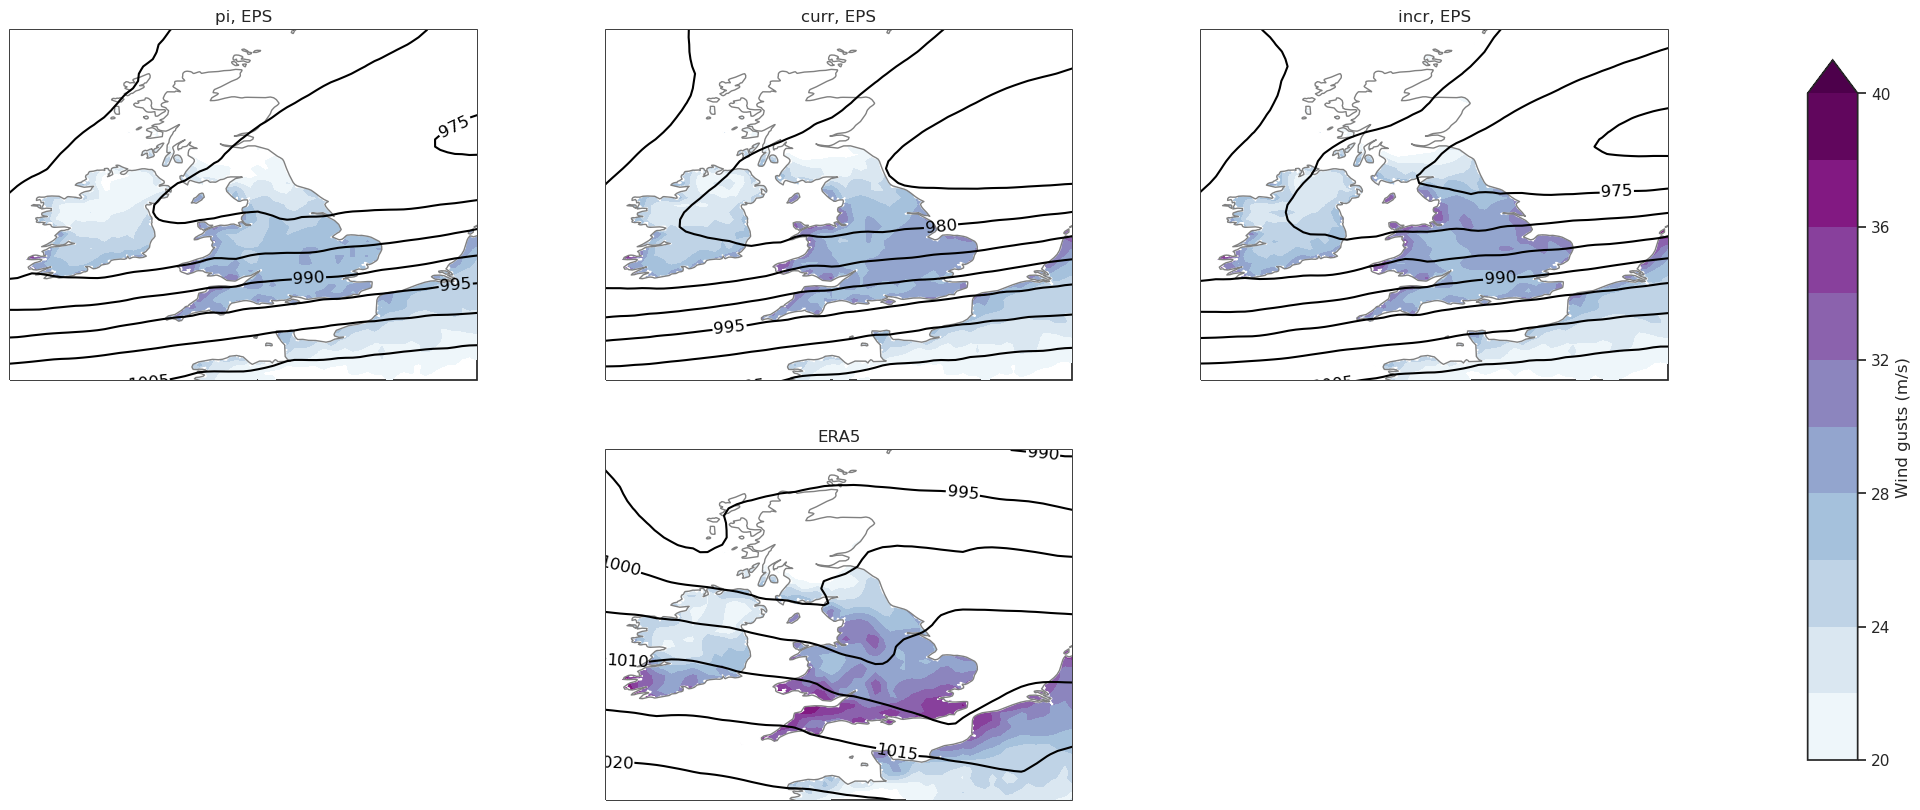

In [27]:
# figure and map setup
projection = ccrs.PlateCarree()
p_max = 1040
p_min = 960

fg10_min = 20
fg10_max = 40

fig = plt.figure(1, figsize=(25, 10))

# EPS data ------------------    
latitude = minimum_pres_eps['pi'].latitude
longitude = minimum_pres_eps['pi'].longitude

for e, experiment in enumerate(experiments):
    p_vals = minimum_pres_eps[experiment].values/100
    fg10_vals = maximum_gusts_eps[experiment].values

    ax = plt.subplot(2,3,e+1,projection = projection)
    ax.set_extent(uk, projection)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
    ax.add_feature(cfeature.OCEAN, zorder=12, color = 'white')  #zorder > 10

    # fg10 as shading
    clevs_fg10 = np.linspace(fg10_min, fg10_max, 11)  # 17
    cf = ax.contourf(longitude, latitude, fg10_vals, clevs_fg10, cmap=plt.cm.BuPu,
                    transform=projection, zorder = 10, extend = 'max')

    # isobars as contours
    clevs_p = np.linspace(p_min, p_max, 17) 
    cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='black',
                    transform=projection, zorder = 16)
    plt.clabel(cs, fmt='%d')
    ax.set_title(experiment+", EPS")


# ERA5 data ----------------------
latitude = minimum_pres_era5.latitude
longitude = minimum_pres_era5.longitude

p_vals = minimum_pres_era5.values/100
fg10_vals = maximum_gusts_era5.values
ax = plt.subplot(2,3,5,projection = projection)
ax.set_extent(uk, projection)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
ax.add_feature(cfeature.OCEAN, zorder=12, color = 'white')  #zorder > 10

# fg10 as shading
clevs_fg10 = np.linspace(fg10_min, fg10_max, 11)  # 17
cf = ax.contourf(longitude, latitude, fg10_vals, clevs_fg10, cmap=plt.cm.BuPu,
                transform=projection, zorder = 10, extend = 'max')

# isobars as contours
clevs_p = np.linspace(p_min, p_max, 17) 
cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='black',
                transform=projection, zorder = 16)
plt.clabel(cs, fmt='%d')
ax.set_title("ERA5")


# Other figure settings -----------------
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(cf, cax=cbar_ax, label='Wind gusts (m/s)', extend = 'max')

# plt.savefig('figures/08_maximum_gust_maps_inidate'+inidate+'.png')
# plt.savefig('figures/08_maximum_gust_maps_inidate'+inidate+'.pdf')

In [28]:
maximum_gusts_eps = eps['curr'].sel(time = slice('2022-02-18 06', '2022-02-18 23')).fg10.max(dim = ["time"])
minimum_pres_eps = eps['curr'].sel(time = slice('2022-02-18 06', '2022-02-18 23')).msl.max(dim = ["time"])

/home/e/ermis/nobackups/miniconda3/envs/storm_eunice39/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


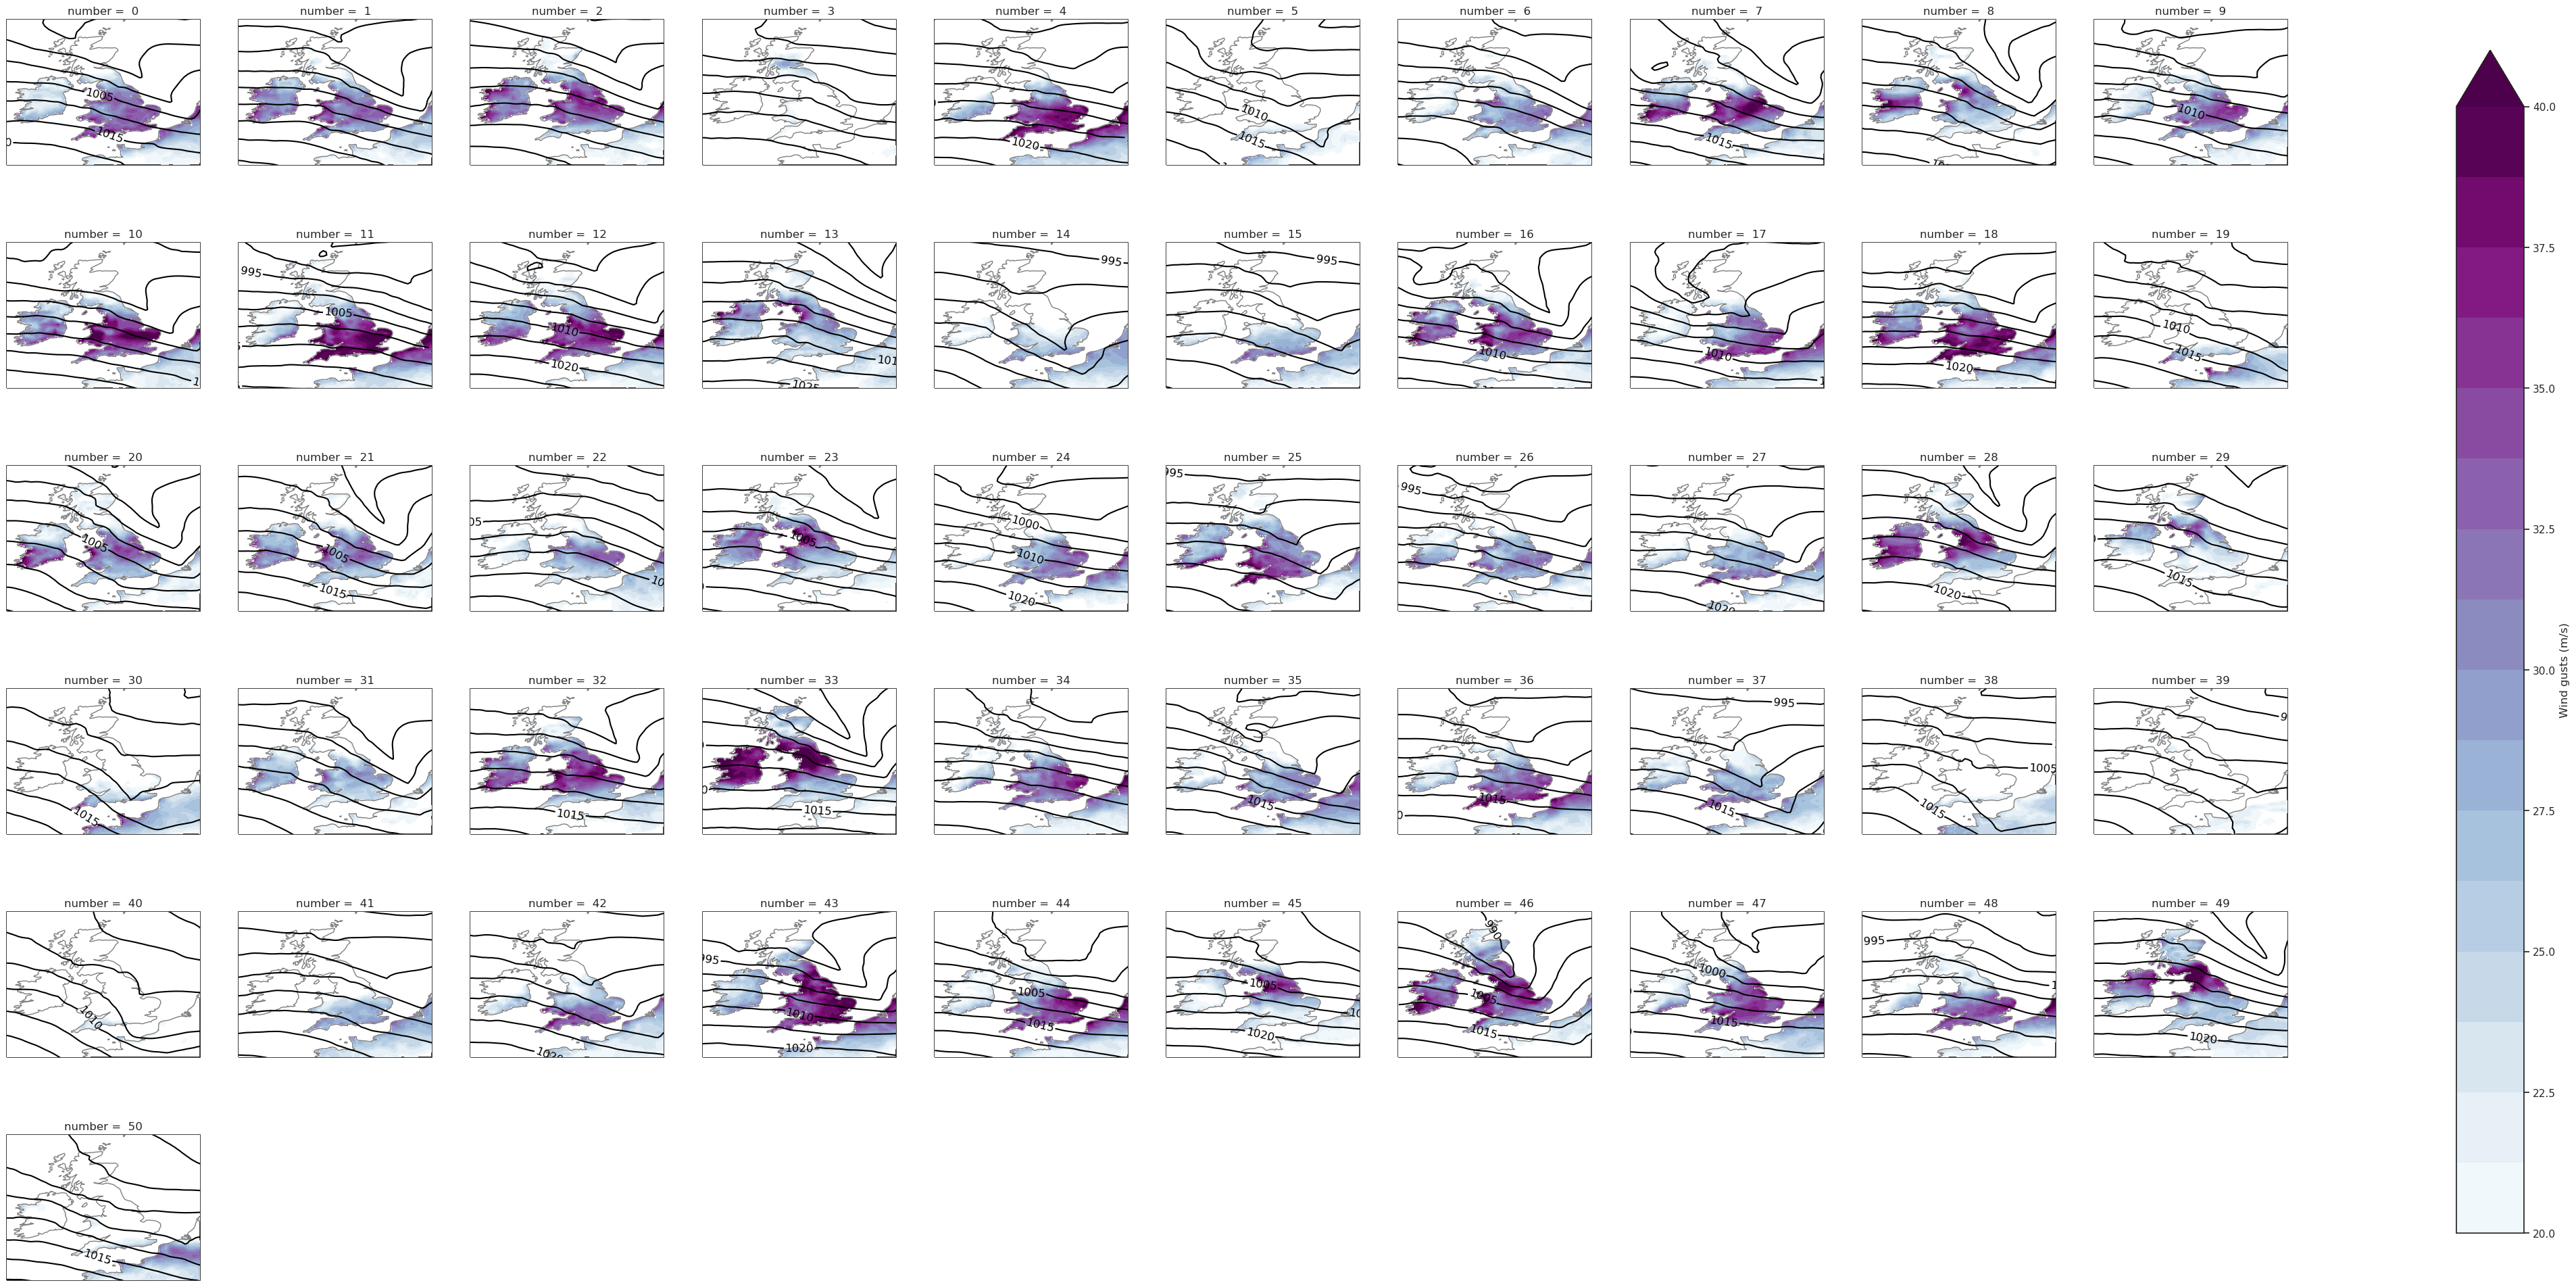

In [29]:
projection = ccrs.PlateCarree()
p_max = 1040
p_min = 960

fg10_min = 20
fg10_max = 40

latitude = minimum_pres_eps.latitude
longitude = minimum_pres_eps.longitude

# figure and map setup
fig = plt.figure(1, figsize=(50,25))
ax = plt.subplot(projection = projection)

for m in range(51):
    fg10_vals = maximum_gusts_eps.sel(number = m)
    p_vals = minimum_pres_eps.sel(number = m)/100

    # figure and map setup
    ax = plt.subplot(6,10,m+1, projection = projection)
    # figure and map setup
    ax.set_extent(uk, projection)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
    ax.add_feature(cfeature.OCEAN, zorder=12, color = 'white')  #zorder > 10

    # fg10 as shading
    clevs_fg10 = np.linspace(fg10_min, fg10_max, 17)
    cf = ax.contourf(longitude, latitude, fg10_vals, clevs_fg10, cmap=plt.cm.BuPu,
                    transform=projection, zorder = 10, extend = "max")

    # isobars as contours
    clevs_p = np.linspace(p_min, p_max, 17)
    cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='black',
                    transform=projection, zorder = 16)
    plt.clabel(cs, fmt='%d')

    ax.set_title("number =  "+ str(m))

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(cf, cax=cbar_ax, label='Wind gusts (m/s)', extend = 'max')

# Storm severity index (SSI)

Here, we use the definition proposed by Leckebusch et al. 2018 which is dependent on the cube of the wind speeds, the duration and the affected area.
$$ SSI_{T, K} = \sum_t^T \sum_k^K \Big[ \Big( \max{(0, \frac{v_{k,t}}{v_{Perc, k}}-1)}\Big)^3 \times A_k\Big].  $$

For this definition, we first need to calculate the 98th percentile of wind speeds. The threshold for each gridbox is determined on the basis of the 10 preceding years of ERA5, assuming a stationary climate.

In [ ]:
era5_windspeeds_98perc = eun.data.Data.get_era_98thperc_winds()
era5_windgusts_98perc = eun.data.Data.get_era_98thperc_gusts()

In [ ]:
def calcArea(lat, lon): 
    degToRad = np.pi / 180
    diffLat, diffLon = -np.diff(lat).mean(), np.diff(lon).mean()
    llat, llon = np.meshgrid(lat,lon)
    llatHalf, llonHalf = (llat+diffLat/2)*degToRad, (llon+diffLon/2)*degToRad
    radius = 6371
    areas = radius**2 * np.diff(llonHalf, axis = 0)[:,:-1] * -((np.cos(llatHalf[:,:-1]) - np.cos(llatHalf[:,1:])))[:-1,:]
    return np.transpose(areas)

In [ ]:
def calcSSI(perc98, forecast, type = 'gust'):

    temp = []
    areas = calcArea(forecast.latitude.values, forecast.longitude.values)

    for time in forecast.time:
        forecastStep = forecast.sel(time = time)
        if type == 'gust':
            windMax = forecastStep.where((forecastStep.fg10/perc98.fg10-1)**3> 0).fg10.values[1:,1:]
        elif type == 'speed':
            windMax = forecastStep.where((forecastStep.windspeeds/perc98.windspeeds-1)**3> 0).fg10.values[1:,1:]
        else:
            raise(ValueError("Type should be one of speed or gust"))
        temp.append(np.nansum(np.multiply(windMax, areas)))
    ssi = np.nansum(temp)
    return ssi/10**9

In [ ]:
ssiGust = {'pi' : [], 'curr' : [], 'incr': []}
ssiSpeed = {'pi' : [], 'curr' : [], 'incr': []}
for experiment in experiments:
    for mem in range(51):
        ssiGust[experiment].append(calcSSI(era5_windgusts_98perc, eps[experiment].sel(time = slice('2022-02-16', '2022-02-18'), number = mem)))
        ssiSpeed[experiment].append(calcSSI(era5_windspeeds_98perc, eps[experiment].sel(time = slice('2022-02-16', '2022-02-18'), number = mem), type = "speed"))

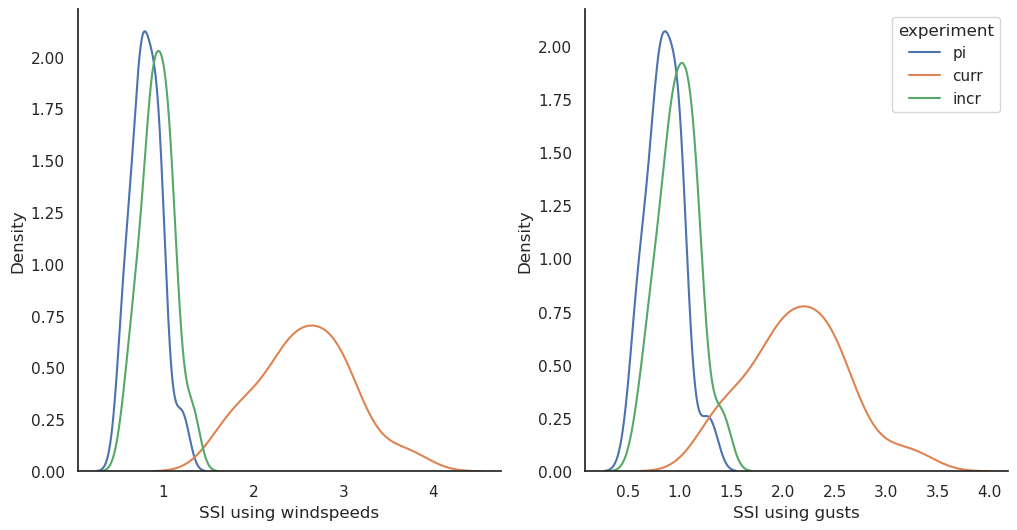

<Figure size 640x480 with 0 Axes>

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols =2, figsize = (12,6))

for experiment in experiments: 
    sns.kdeplot(ssiSpeed[experiment], label = experiment, ax=ax1)
    ax1.set_xlabel("SSI using windspeeds")
    sns.kdeplot(ssiGust[experiment], label = experiment, ax = ax2)
    ax2.set_xlabel("SSI using gusts")
    

sns.despine()
plt.legend(title = "experiment")
plt.show()

plt.savefig('figures/08_SSI_distributions_inidate_'+inidate+'.png')
plt.savefig('figures/08_SSI_distributions_inidate_'+inidate+'.pdf')